In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy as sc
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from IPython.display import Image
from IPython.display import display
%matplotlib inline

In [2]:
# read in data
raw_loan_data = pd.read_csv('loan.csv')

In [3]:
# filter for relevant columns
relevant_cols = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
# save filtered data to avoid reading large raw data file again
raw_loan_data[relevant_cols].to_csv('filtered_loan_data.csv', index = False)

In [4]:
# read in filtered data
filtered_loan_data = pd.read_csv('filtered_loan_data.csv')

In [5]:
# sanity check that number of rows has remained constant in filtering
filtered_loan_data.shape

(2260668, 11)

# Part 1: Data Exploration and Evaluation

Part 1 consists of four sections:

#### Section 1A: Handling Missing Values
#### Section 1B: Exploring Categorical Variables - Transformations
#### Section 1C: Exploring Numerical Variables - Managing Outliers
#### Section 1D: Cross Variable Exploration

#### Section 1A: Handling Missing Values

In [6]:
# preview filtered data
filtered_loan_data.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,2500,2500,36 months,13.56,C,55000.0,Dec-2018,18.24,4341,167.02,Current
1,30000,30000,60 months,18.94,D,90000.0,Dec-2018,26.52,12315,1507.11,Current
2,5000,5000,36 months,17.97,D,59280.0,Dec-2018,10.51,4599,353.89,Current
3,4000,4000,36 months,18.94,D,92000.0,Dec-2018,16.74,5468,286.71,Current
4,30000,30000,60 months,16.14,C,57250.0,Dec-2018,26.35,829,1423.21,Current


In [7]:
# count of values by variable
filtered_loan_data.count()

loan_amnt      2260668
funded_amnt    2260668
term           2260668
int_rate       2260668
grade          2260668
annual_inc     2260664
issue_d        2260668
dti            2258957
revol_bal      2260668
total_pymnt    2260668
loan_status    2260668
dtype: int64

In [8]:
# a version of our dataset with no missing values
filtered_loan_data_no_missing = filtered_loan_data.dropna()
filtered_loan_data_no_missing.shape

(2258953, 11)

In [9]:
# missing values are less than 0.1% of data
(filtered_loan_data.shape[0] - filtered_loan_data_no_missing.shape[0]) / filtered_loan_data.shape[0] * 100

0.0758625326673355

Given the very low incidence (< 0.1%) of missing values, we can exclude them from the analysis. If missing values were of higher incidence, then we could impute them using a means or regression method.

#### Section 1B: Exploring Categorical Variables - Transformations

In [10]:
numerical_vars = filtered_loan_data_no_missing._get_numeric_data().columns.values
categorical_vars = list(filtered_loan_data_no_missing.columns.difference(numerical_vars))
categorical_vars

['grade', 'issue_d', 'loan_status', 'term']

In [11]:
# summary statistics on categorical variables
filtered_loan_data_no_missing[categorical_vars].describe()

,grade,issue_d,loan_status,term
count,2258953,2258953,2258953,2258953
unique,7,139,9,2
top,B,Mar-2016,Fully Paid,36 months
freq,663120,61979,1041702,1608745


The above summary statistics table suggests that grade, loan status and term are good candidates for conversion to dummy variables (given their relatively small number of unique values) while issue date is not (139 unique values). 

Issue date needs to be coded to capture the information its conveying, an indicator of months since origination.

In [12]:
# code grade, loan status and term as dummies
# in our logistic regression model we will have n-1 dummies for n categories but keep n for now for visualization purposes
filtered_loan_data_cat_fix_1 = pd.get_dummies(filtered_loan_data_no_missing, columns = ['grade', 'loan_status', 'term'])

In [13]:
# format issue date as datetime for subtraction
filtered_loan_data_cat_fix_1['issue_d_clean'] = pd.to_datetime(filtered_loan_data_cat_fix_1['issue_d'], format='%b-%Y')

In [14]:
today_date = datetime.date.today()

In [15]:
# create months since issue varriable
filtered_loan_data_cat_fix_1['months_since_issue'] = ((today_date - filtered_loan_data_cat_fix_1['issue_d_clean'])/np.timedelta64(1, 'M')).astype(int)

In [16]:
# we don't need issue_d anymore
filtered_loan_data_cat_fixed = filtered_loan_data_cat_fix_1[filtered_loan_data_cat_fix_1.columns.difference(['issue_d', 'issue_d_clean'])]

The distributions of categorical variabes below show that A,B,C grades and 36 month loans are most frequent in the data set. Furthermore, the most common loan statuses are fully paid or current. Finally, most loans in the data set have been issued in the past 5 years, with some far back reaching outliers

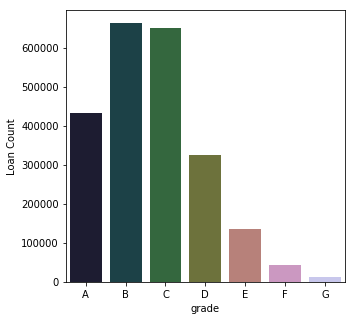

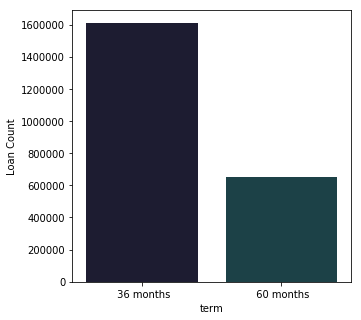

In [17]:
# category distributions for grade and term
# These show that A,B,C grades and 36 month loans are most frequent
for var in ['grade', 'term']:
    plt.figure(figsize = (5,5))
    sns.barplot(x=var, y='int_rate', data = filtered_loan_data.groupby(var)['int_rate'].count().reset_index(), palette = sns.color_palette("cubehelix", 8))
    plt.ylabel("Loan Count")

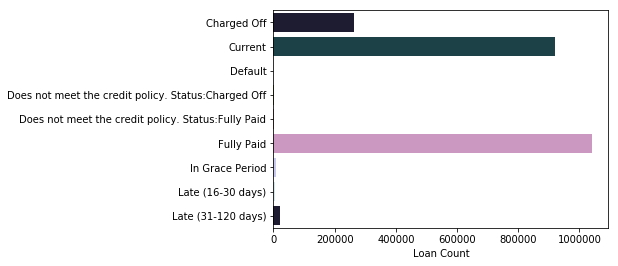

In [18]:
# category distribution for loan_status
# These show that majority of loans are fully paid or current
plt.figure()
sns.barplot(y='loan_status', x='int_rate', data = filtered_loan_data.groupby('loan_status')['int_rate'].count().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("")
plt.xlabel("Loan Count")

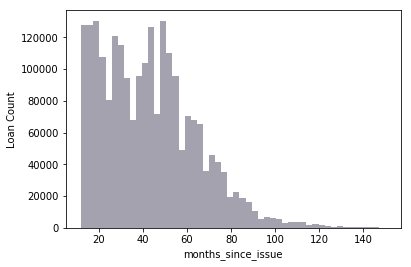

In [19]:
# distribution of months since issue - majority under 5 years with some far reaching outliers
sns.set_palette(palette = sns.color_palette("cubehelix", 8))
sns.distplot(filtered_loan_data_cat_fixed['months_since_issue'], kde = False)
plt.ylabel("Loan Count")

#### Section 1C: Exploring Numerical Variables - Managing Outliers

In [20]:
#summarize numerical variables
filtered_loan_data_cat_fixed[numerical_vars].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06,2.25895e+06
mean,15043.9,15038.6,13.0921,78051.5,18.8242,16658.9,11827.2
std,9188.07,9186.24,4.83136,112718,14.1833,22945.4,9890.39
min,500,500,5.31,0,-1,0,0
25%,8000,8000,9.49,46000,11.89,5951,4274.47
50%,12900,12850,12.62,65000,17.84,11325,9065.12
75%,20000,20000,15.99,93000,24.49,20247,16712.6
max,40000,40000,30.99,1.1e+08,999,2.90484e+06,63296.9


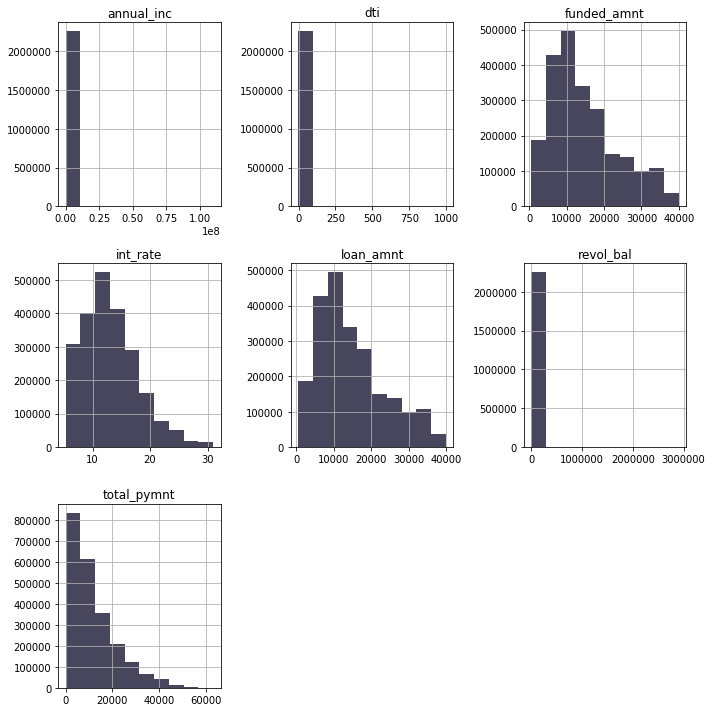

In [21]:
# distributions of numerical variables
axh = filtered_loan_data_cat_fixed[numerical_vars].hist(figsize=(10,10), alpha = 0.8)
figsize=(20, 10)
plt.tight_layout()
plt.show()

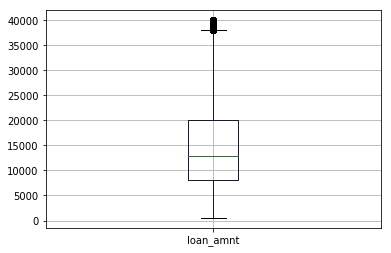

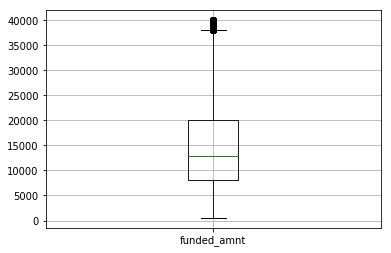

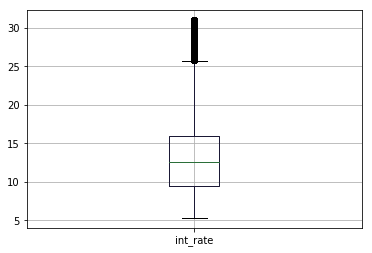

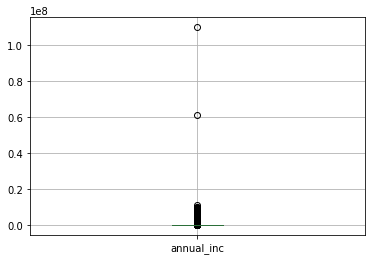

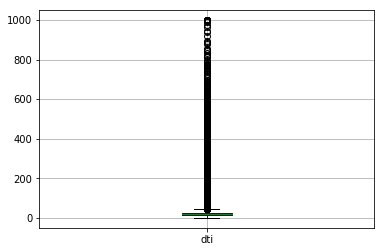

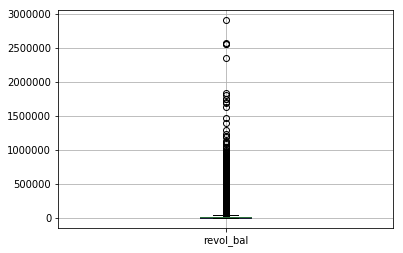

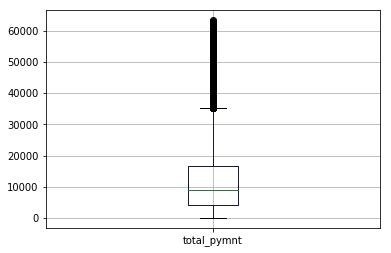

In [22]:
# box plots of each numerical variable
for column in filtered_loan_data_cat_fixed[numerical_vars]:
    plt.figure()
    filtered_loan_data_cat_fixed.boxplot([column])

The pictures above shows the highest incidence of outliers in revolving balance, dti, annual income and total payment. This result is logical in that these variables are most sensitive to individual customer situations and are thus most impacted by outlier customers

In [23]:
# create version of dataset with outliers removed using 1.5 IQR rule
filtered_loan_data_no_outliers = filtered_loan_data_cat_fixed.copy()
for col in numerical_vars:
    Q1 = filtered_loan_data_no_outliers[col].quantile(0.25)
    Q3 = filtered_loan_data_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    filtered_loan_data_no_outliers = filtered_loan_data_no_outliers[(filtered_loan_data_no_outliers[col] >= (Q1-1.5*IQR)) & (filtered_loan_data_no_outliers[col] <= (Q3+1.5*IQR))] 

In [24]:
# droping observations with outliers removes ~ 16% of the data
(filtered_loan_data_cat_fixed.shape[0] - filtered_loan_data_no_outliers.shape[0]) / filtered_loan_data_cat_fixed.shape[0] * 100

16.468691469012413

Given, the relatively large % of the data that is removed when dropping all observations with outliers, we cannot simply remove outliers as they may be a reflect significant underlying features of the data. Given the high-incidence of outliers, the following configurations will be tested in the predictive model: a model with all outliers, a model excluding all outliers, a model with outliers winsorized 5% on each side. A 5% threshold is chosen as given the high outlier precense in the data set, a relatively high winsorization threshold is needed for winsorization to have the intended effect.

In [25]:
filtered_loan_data_winsorized = filtered_loan_data_cat_fixed.copy()
for col in numerical_vars: 
     filtered_loan_data_winsorized[col] = sc.stats.mstats.winsorize(filtered_loan_data_winsorized[col], limits=0.05)

In [26]:
# now we have three datasets - regular, no outliers and winsorized
filtered_loan_data_regular = filtered_loan_data_cat_fixed.copy()
dfs_list = [filtered_loan_data_regular, filtered_loan_data_no_outliers, filtered_loan_data_winsorized]

In [27]:
continuous_vars = np.append(numerical_vars, 'months_since_issue')

#### Section 1D: Cross Variable Exploration

First, we explore relationships between each of the covariates themselves and then we explore the relationship between covariates and loan default.

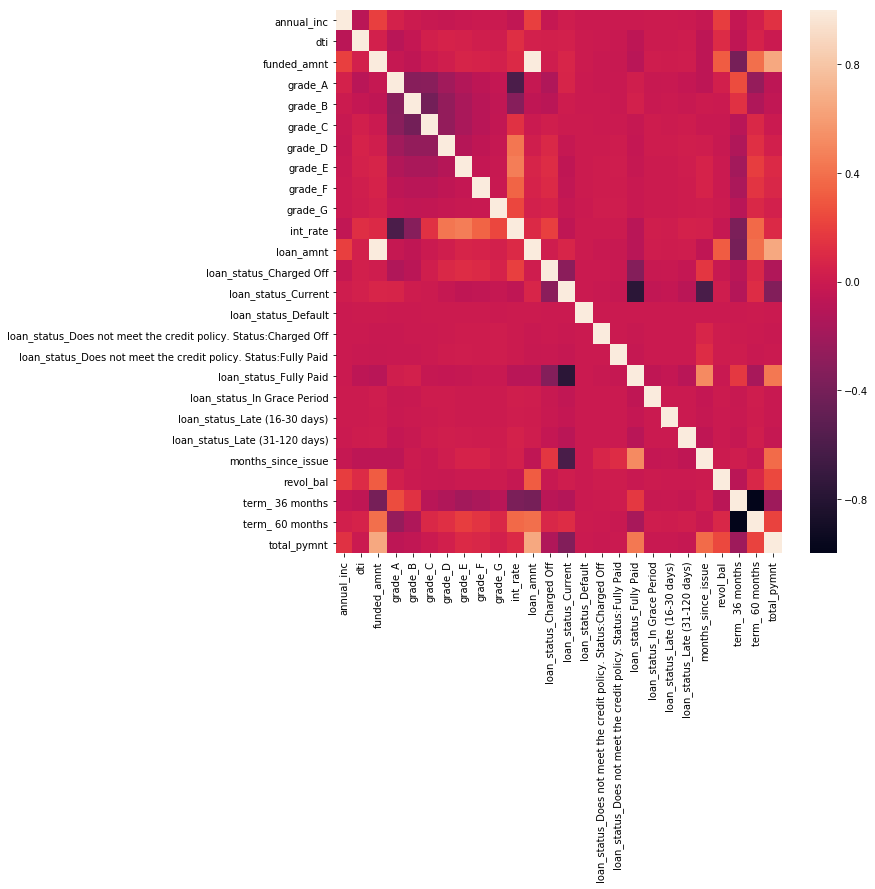

In [28]:
# heat map of correlation between variables
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(np.corrcoef(filtered_loan_data_regular.T), ax=ax)
ax.set_xticklabels(filtered_loan_data_regular.columns, rotation='vertical')
ax.set_yticklabels(filtered_loan_data_regular.columns, rotation='horizontal')
plt.show()

The heatmap above displayes interesting and potentially collinear relationships between interest rate and grade and loan amount and funded amount. We investigate both below.

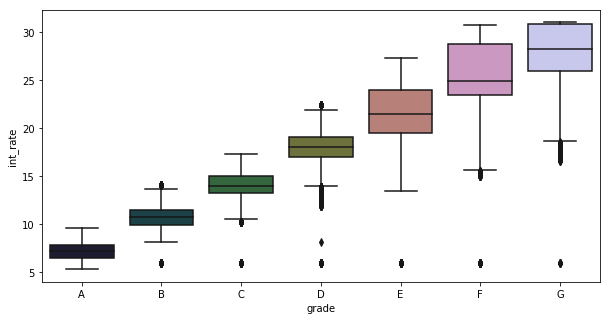

In [29]:
# relationship between interest rate and grade
# These appear quite colinear, especially after excluding outliers
# grade likely isn't needed in the model if interest rate is already there
plt.figure(figsize = (10,5))
sns.boxplot(x="grade", y="int_rate", data=filtered_loan_data, order = ['A', 'B','C', 'D', 'E', 'F', 'G'])
plt.show()

The above chart shows a clear relationship between grade and interest rate (lower grade is asssociated with higher interest rate). This implies that the two are likely collinear and both don't need to be in our predictive model.

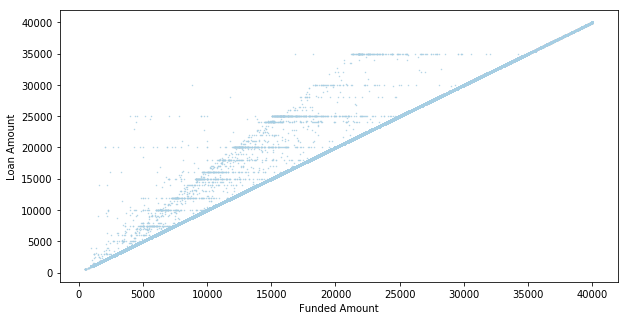

In [30]:
sns.set_palette(sns.color_palette("Paired"))

x = filtered_loan_data_regular['funded_amnt'].values
y = filtered_loan_data_regular['loan_amnt'].values

plt.figure(figsize = (10,5))
plt.scatter(x=x, y=y, s = 0.2)
plt.xlabel('Funded Amount')
plt.ylabel('Loan Amount')

The scatter of loan amount and funded amount above indicates that while the two are similar and correlated there are a non-negligible amount of cases where the loan amount has been adjusted upward. Removing one of these variables from our model may lead to missing the potential impact of this upward adjustment on default. Thus, we will leave both in our model.

Next, we explore the relationship between our covariates and the dependent variable (default rate) to gauge which covariates may be good individual predictors of default. First, we need to isolate our population of interest for studying defaults (36-month term with >= 36 months of data)

In [31]:
# create months since issue variable
filtered_loan_data['issue_d_clean'] = pd.to_datetime(filtered_loan_data_cat_fix_1['issue_d'], format='%b-%Y')
filtered_loan_data['months_since_issue'] = ((today_date - filtered_loan_data_cat_fix_1['issue_d_clean'])/np.timedelta64(1, 'M')).astype(int)

In [32]:
# isolate 36 month term loans that have have >= 36 months of data
loan_data_36 = filtered_loan_data[(filtered_loan_data['term'] == ' 36 months') & (filtered_loan_data['months_since_issue'] >= 36.0)]

In [33]:
# create fully paid variable
loan_data_36 = loan_data_36.copy()
loan_data_36['Fully_Paid'] = [1 if x in ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'] else 0 for x in loan_data_36['loan_status']]

In [34]:
# create default dependent variable as loans not fully paid
loan_data_36 = loan_data_36.copy()
loan_data_36['Default'] = [1 if x == 0 else 0 for x in loan_data_36['Fully_Paid']]

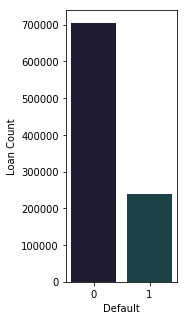

In [35]:
# How are defaults distributed?
# ~75-25 ratio between defaults and not
plt.figure(figsize = (2,5))
sns.barplot(x='Default', y='int_rate', data = loan_data_36.groupby('Default')['int_rate'].count().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Loan Count")

As shown in the figure above, on average, defaults occur ~25% of the time in the dataset with 36-month loans that were issued at least 36-months ago. Furthermore, the distribution of continuous co-variates by defaults and non-defaults below show that interest rate, revolving balance, total payments and months since issue to be more promising predictors of default as these factors show the least overlap in their distribution for defaults and non-defaults.

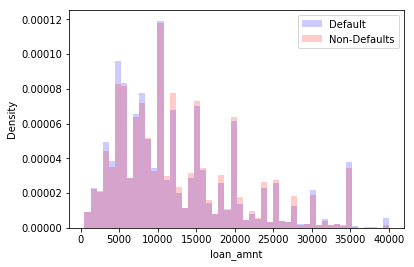

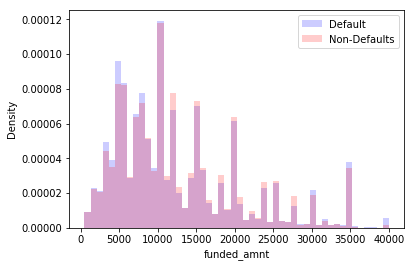

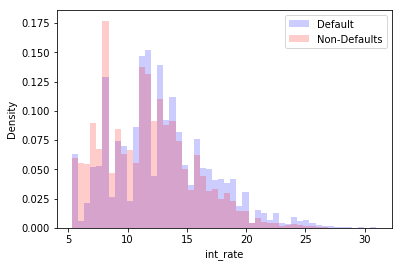

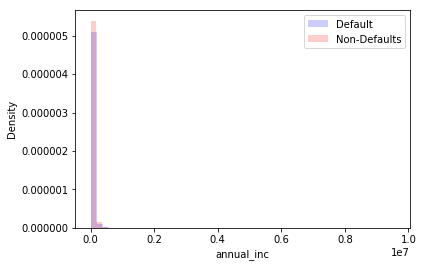

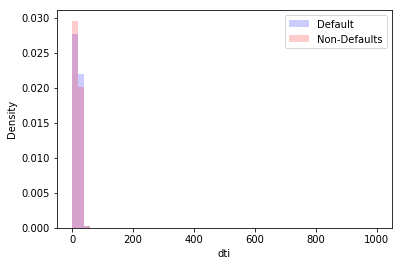

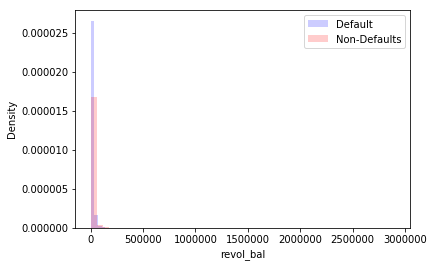

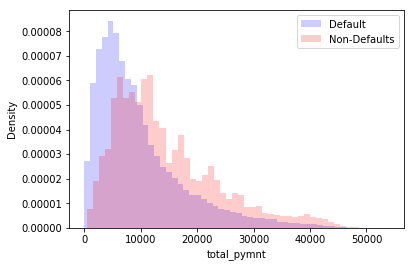

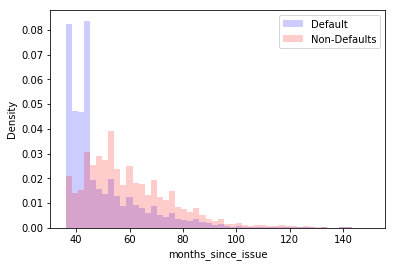

In [36]:
# plot distribution of covariates by default status
for var in continuous_vars:
    defaults = loan_data_36[loan_data_36['Default']==1][var]
    non_defaults = loan_data_36[loan_data_36['Default']==0][var]
    plt.hist(defaults, bins = 50, alpha=0.2, label='Default', color = 'blue', normed=True)
    plt.hist(non_defaults, bins = 50, alpha=0.2, label='Non-Defaults', color = 'red', normed= True)
    plt.legend(loc='upper right')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

The figure below also shows a clear relationship between defaulting and grades; lower grade loans are more likely to default.

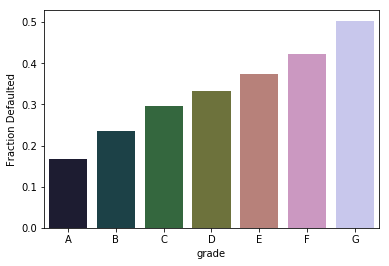

In [37]:
# loan defaults by grade - with status being colinear and term limited to 36 months, this is the only categorical variable that may be in the model
sns.barplot(x='grade', y='Default', data = loan_data_36.groupby('grade')['Default'].mean().reset_index(), palette = sns.color_palette("cubehelix", 8))
plt.ylabel("Fraction Defaulted")

# Part 2: Business Analysis

Part 2 consists of three sections:
#### Section 2A: Percentage of Loans Fully Paid
#### Section 2B: Cohort analysis - Percent Default
#### Section 2C: Cohort analysis - Annualized Rate of Return

For the business analysis, I use the full dataset as these metrics will generally not be skewed by outliers (especially the percent defaults which are a 0 or 1 variable). Additionally, with a high incidence of outliers in the data set, they likely capture a representative feature of the data and should be included.

#### Section 2A: Percentage of Loans Fully Paid

In [38]:
# ~75% of loans fully paid
loan_data_36[loan_data_36['Fully_Paid'] == 1].shape[0] / loan_data_36.shape[0] * 100

74.61002713268977

~75% of loans with 36 month terms that have existed for 36 or more months have been fully paid

#### Section 2B: Cohort Analysis - Percent Default

In [39]:
loan_data_36 = loan_data_36.copy()
loan_data_36['year_is'] = loan_data_36['issue_d_clean'].map(lambda x: x.year)

In [40]:
default_cohorts = pd.crosstab(loan_data_36['grade'], loan_data_36['year_is'], values = loan_data_36['Default'], aggfunc='mean')
default_cohorts

year_is,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
grade,,,,,,,,,,
A,0.054054,0.059748,0.067332,0.043631,0.063990,0.072352,0.045612,0.053831,0.054583,0.407670
B,0.163265,0.173401,0.121799,0.096257,0.105676,0.125677,0.097859,0.107239,0.119793,0.459329
C,0.241135,0.210345,0.152819,0.135266,0.155243,0.175722,0.152958,0.171950,0.195156,0.498375
D,0.313131,0.264916,0.179927,0.185954,0.180809,0.211478,0.203930,0.221745,0.263264,0.535335
E,0.310000,0.263158,0.217532,0.196429,0.205882,0.218868,0.233055,0.270309,0.329524,0.565646
F,0.480769,0.342342,0.266667,0.296703,0.240741,0.184466,0.268092,0.294949,0.424798,0.599238
G,0.485714,0.325581,0.327273,0.352941,0.400000,0.166667,0.266667,0.363128,0.467742,0.649057


In [41]:
# The maximum value of ~65% is for Grade G loans issued in 2016
max(default_cohorts.max().values)

0.64905660377358487

As shown in the heat map below, Grade G loans issued in 2016 have the highest rate of default of ~65%

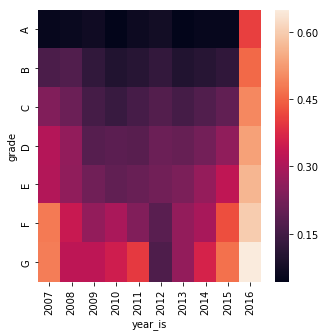

In [42]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(default_cohorts, ax=ax)

#### Section 2C: Cohort Analysis - Rate of Return

In [43]:
loan_data_36 = loan_data_36.copy()
loan_data_36['ROR'] = (loan_data_36['total_pymnt'] / loan_data_36['funded_amnt']) ** (1/3) - 1

In [44]:
returns_crosstab = pd.crosstab(loan_data_36['grade'], loan_data_36['year_is'], values = loan_data_36['ROR'], aggfunc='mean')
returns_crosstab

year_is,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
grade,,,,,,,,,,
A,0.026455,0.023488,0.021457,0.021672,0.014997,0.015804,0.024873,0.021949,0.019434,0.000040
B,-0.001857,-0.000276,0.014551,0.022018,0.022047,0.023704,0.030172,0.025857,0.018160,-0.004799
C,-0.008002,-0.003972,0.012092,0.022437,0.017920,0.022367,0.030388,0.021428,0.011119,-0.011267
D,-0.013119,-0.018201,0.014316,0.012707,0.022120,0.024695,0.028380,0.017577,0.002413,-0.018782
E,-0.015043,-0.003274,-0.000189,0.014385,0.025079,0.032345,0.028680,0.013843,-0.010299,-0.028032
F,-0.079793,-0.044362,0.002747,-0.007690,0.022408,0.033400,0.020588,0.018980,-0.026656,-0.038491
G,-0.044028,-0.007825,0.003100,-0.007570,-0.020228,0.043012,-0.007625,0.005299,-0.044741,-0.063593


As shown in the heat map below, returns generally improve with higher grade (e.g. going from G to A) but are variable over time.

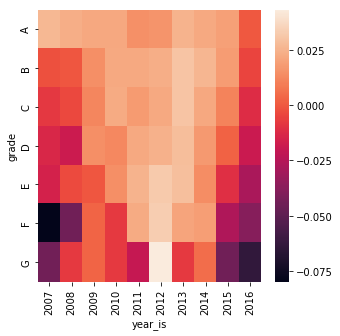

In [45]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.heatmap(returns_crosstab, ax=ax)

# Part 3: Modeling

Part 3 consists of four sections:

#### Section 3A: Generate train and test set and standardize data
#### Section 3B: Cross-validate and run logisitic regression
#### Section 3C: Analyze effectivness using ROC curves

#### Section 3A: Generate train and test set and standardize data based on training

75% of the data is randomly assigned as the training set – on which the predictive model will be calibrated and calculated and 25% is assigned as the test set on which on the model will be tested for prediction accuracy. 

This train-test split will prevent over-fitting (e.g. good model performance on a subset of data but not generalizing well).

In [46]:
# create training and test sets
train_dfs_dict = {}
test_dfs_dict = {}
key_list = []
for df in dfs_list:
    #filter to scope of 36 month term loans with >= 36 months of data
    df_filtered = df[(df['term_ 36 months'] == 1) & (df['months_since_issue'] >=36)]
    # create dependent variable
    df_filtered = df_filtered.copy()
    df_filtered['default'] = [1 if (x==0) & (y==0) else 0 for x,y in zip(df_filtered['loan_status_Fully Paid'], df_filtered['loan_status_Does not meet the credit policy. Status:Fully Paid'])]
    # remove loan status as this is collinear with dependent variable
    # make sure there are n-1 dummies for each dummy variable
    # remove grade because of collinearity with interest rate
    features = ['default','annual_inc', 'dti', 'int_rate', 'loan_amnt', 'funded_amnt', 'months_since_issue', 'revol_bal', 'total_pymnt']
    df_filtered_features = df_filtered[features]
    np.random.seed(9001)
    msk = np.random.rand(len(df_filtered_features)) < 0.75
    data_train =  df_filtered_features[msk]
    data_test =  df_filtered_features[~msk]
    key =[x for x in globals() if globals()[x] is df][0]
    key_list.append(key)
    train_dfs_dict[key] = data_train
    test_dfs_dict[key] = data_test

In [47]:
# standardize numerical variables
std_train_dfs_dict = {}
std_test_dfs_dict = {}
for key in key_list:
    train_df = train_dfs_dict[key]
    test_df = test_dfs_dict[key]
    mean = train_df[continuous_vars].mean()
    std = train_df[continuous_vars].std()
    std_train_df = train_df.copy()
    std_test_df = test_df.copy()
    std_train_df[continuous_vars] = (std_train_df[continuous_vars] - mean)/std
    std_test_df[continuous_vars] = (std_test_df[continuous_vars] - mean)/std
    std_train_dfs_dict[key] = std_train_df
    std_test_dfs_dict[key] = std_test_df

#### Section 3B: Cross-validate and run logistic regression

Logistic Regression CV runs 5-fold cross validation to optimize its parameters for prediction accuracy and then runs the cross-validated model on the training data. The classifier is run on the model with outliers, model without outliers and model with winsorized outliers.


In [48]:
# store dependent variable
y_train_dict = {}
y_test_dict = {}
for key in key_list: 
    y_train_dict[key] = std_train_dfs_dict[key]['default']
    y_test_dict[key] = std_test_dfs_dict[key]['default']

In [49]:
# run logistic regression
train_accuracy_dict = {}
test_accuracy_dict = {}
roc_curve_dict = {}
for key in key_list:
    logregcv = LogisticRegressionCV()
    X_train = std_train_dfs_dict[key][std_train_dfs_dict[key].columns.difference(['default'])]
    y_train = y_train_dict[key]
    X_test = std_test_dfs_dict[key][std_test_dfs_dict[key].columns.difference(['default'])]
    y_test = y_test_dict[key]
    logregcv.fit(X_train, y_train)
    y_hat_train = logregcv.predict(X_train)
    y_hat_test = logregcv.predict(X_test)
    train_accuracy_dict[key] = accuracy_score(y_train, y_hat_train)
    test_accuracy_dict[key] = accuracy_score(y_test, y_hat_test)
    preds = logregcv.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    roc_curve_dict[key] = (fpr, tpr, roc_auc)

In terms of prediction accuracy, our model does quite well, around 91% for the model with outliers, 92% for the model with no outliers and 88% for the model with winsorized outliers. Additionally, all of the aforementioned calibrations beat the naïve baseline of assuming no defaults (around 75% accuracy) or randomly guessing defaults 1/4th of the time (around 63% accuracy).

In [50]:
# training accuracy
print(train_accuracy_dict)

{'filtered_loan_data_regular': 0.91248679204292005, 'filtered_loan_data_no_outliers': 0.91719868849934549, 'filtered_loan_data_winsorized': 0.87679815137976425}


In [51]:
# test accuracy
print(test_accuracy_dict)

{'filtered_loan_data_regular': 0.91288322220525608, 'filtered_loan_data_no_outliers': 0.91789540681022597, 'filtered_loan_data_winsorized': 0.87765307680561921}


In [52]:
# how do these accuracies compare to a naive classifier that assumes nobody defaults
for key in key_list:
    logregcv = LogisticRegressionCV()
    print("Train accuracy: " + key, accuracy_score(y_train_dict[key], [0 for y in y_train_dict[key]]))
    print("Test accuracy: " + key, accuracy_score(y_test_dict[key], [0 for y in y_test_dict[key]]))

Train accuracy: filtered_loan_data_regular 0.745938861795
Test accuracy: filtered_loan_data_regular 0.746585568619
Train accuracy: filtered_loan_data_no_outliers 0.741556091677
Test accuracy: filtered_loan_data_no_outliers 0.740691630423
Train accuracy: filtered_loan_data_winsorized 0.745938861795
Test accuracy: filtered_loan_data_winsorized 0.746585568619


In [53]:
# how do these accuracies compare to a naive classifier that randomly guesses defaults 1/4th of the time
for key in key_list:
    logregcv = LogisticRegressionCV()
    print("Train accuracy: " + key, accuracy_score(y_train_dict[key], [np.random.choice(np.arange(0, 2), p=[0.75, 0.25]) for y in y_train_dict[key]]))
    print("Test accuracy: " + key, accuracy_score(y_test_dict[key], [np.random.choice(np.arange(0, 2), p=[0.75, 0.25]) for y in y_test_dict[key]]))

Train accuracy: filtered_loan_data_regular 0.622797674553
Test accuracy: filtered_loan_data_regular 0.622465686025
Train accuracy: filtered_loan_data_no_outliers 0.620240677053
Test accuracy: filtered_loan_data_no_outliers 0.620823167498
Train accuracy: filtered_loan_data_winsorized 0.622231971932
Test accuracy: filtered_loan_data_winsorized 0.625371133846


#### Section 3C: Analyze effectiveness using ROC curves

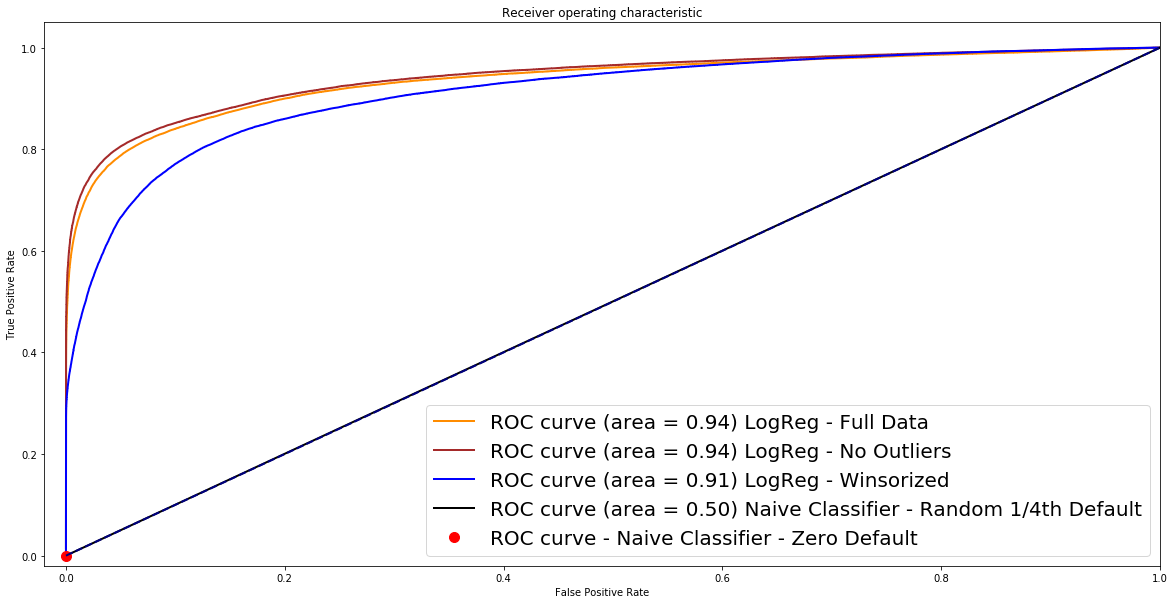

In [54]:
# naive classifier that assumes no default for no outlier case - not very different across each case
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_test_dict[key_list[0]], [0 for y in y_test_dict[key_list[0]]])
roc_auc4 = metrics.auc(fpr4, tpr4)

# naive classifier that assumes default 1/4th of the time randomly for no outlier case - not very different across each case
rand_preds = [np.random.choice(np.arange(0, 2), p=[0.75, 0.25]) for y in y_test_dict[key_list[0]]]
fpr5, tpr5, thresholds_5 = metrics.roc_curve(y_test_dict[key_list[0]], rand_preds)
roc_auc_5 = metrics.auc(fpr5, tpr5)

plt.figure(figsize=(20,10))
lw = 2
# model with outliers
plt.plot(roc_curve_dict[key_list[0]][0], roc_curve_dict[key_list[0]][1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f) LogReg - Full Data' % roc_curve_dict[key_list[0]][2])
# model with no outliers
plt.plot(roc_curve_dict[key_list[1]][0], roc_curve_dict[key_list[1]][1], color='brown',
         lw=lw, label='ROC curve (area = %0.2f) LogReg - No Outliers' % roc_curve_dict[key_list[1]][2])
# model with winsorization
plt.plot(roc_curve_dict[key_list[2]][0], roc_curve_dict[key_list[2]][1], color='blue',
         lw=lw, label='ROC curve (area = %0.2f) LogReg - Winsorized' % roc_curve_dict[key_list[2]][2])
# naive - random guess
plt.plot(fpr5, tpr5, color='black',
         lw=lw, label='ROC curve (area = %0.2f) Naive Classifier - Random 1/4th Default' % roc_auc_5)
# naive - zero defaults
plt.plot([0], [0], marker='o', markersize=10, lw = 0, color="red", label ='ROC curve - Naive Classifier - Zero Default')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", prop={'size':20})
plt.show()

ROC curves show that each calibration of the model has ROC AUC > 0.9 and beats the two naive baselines of assuming no defaults and randomly guessing defaults 1/4th of the time in terms of AUC as well.Thus, the model is validated by prediction accuracy as well as in terms of maximizing the true positive rate while minimizing the false positive rate. Of course, with the AUC < 1, this model is not perfect.